# PROBABILE STRUTTURA
1. Caricamento dei file audio
2. Parsing del filename → estrazione emotion_id
3. Creazione DataFrame per vedere se tutto è corretto  ← QUI metti il codice
4. Generazione dei mel-spectrogram
5. Decisione dei parametri (n_mels, hop, win, durata, padding)
6. Test di un paio di augmentations


In [1]:
#!pip install pandas


In [2]:
import os
os.getcwd()
import sys
sys.path.append("../src")

import pandas as pd
from glob import glob
from preprocessing.dataset import extract_emotion_label, EMOTION_MAP

audio_files = glob("../data/Actor_*/*.wav", recursive=True)
print("Numero totale file:", len(audio_files))
audio_files[:3]

rows = []

for f in audio_files:
    filename = os.path.basename(f)
    parts = filename.split('-')

    emotion_id = parts[2]
    emotion_label = EMOTION_MAP[emotion_id]

    actor = parts[-1].split('.')[0]  # ultimo numero prima del .wav

    rows.append([f, emotion_id, emotion_label, actor])

df = pd.DataFrame(rows, columns=["filepath", "emotion_id", "emotion_label", "actor"])
df.head()



Numero totale file: 1440


,filepath,emotion_id,emotion_label,actor
0,../data\Actor_01\03-01-01-01-01-01-01.wav,01,neutral,01
1,../data\Actor_01\03-01-01-01-01-02-01.wav,01,neutral,01
2,../data\Actor_01\03-01-01-01-02-01-01.wav,01,neutral,01
3,../data\Actor_01\03-01-01-01-02-02-01.wav,01,neutral,01
4,../data\Actor_01\03-01-02-01-01-01-01.wav,02,calm,01


In [3]:
# Verifica della corretta popolazione del dataset

print("=== DATASET CHECK ===\n")

print(f"Totale file audio: {len(df)}\n")

print("Distribuzione emozioni:")
print(df["emotion_label"].value_counts().sort_index(), "\n")

print("Distribuzione attori:")
print(df["actor"].value_counts().sort_index(), "\n")


=== DATASET CHECK ===

Totale file audio: 1440

Distribuzione emozioni:
emotion_label
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: count, dtype: int64 

Distribuzione attori:
actor
01    60
02    60
03    60
04    60
05    60
06    60
07    60
08    60
09    60
10    60
11    60
12    60
13    60
14    60
15    60
16    60
17    60
18    60
19    60
20    60
21    60
22    60
23    60
24    60
Name: count, dtype: int64 



In [4]:
import os
os.getcwd()
import sys
sys.path.append("../src")

torch.Size([16, 1, 128, 126]) torch.Size([16])


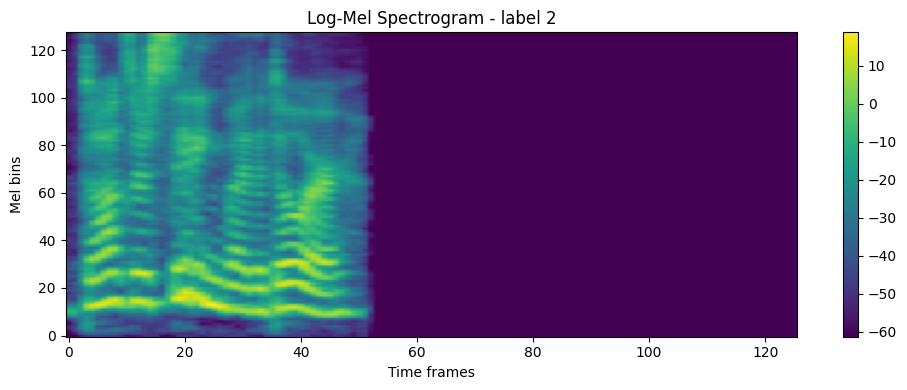

In [5]:

from torch.utils.data import DataLoader
from preprocessing.dataset import list_ravdess_files, split_by_speakers, RavdessDataset, plot_log_mel_from_loader, filter_audio_speech

all_files = list_ravdess_files("../data")
all_files = filter_audio_speech(all_files)

train_spk = [f"{i:02d}" for i in range(1, 19)]   # 01..18
val_spk   = [f"{i:02d}" for i in range(19, 23)]  # 19..22
test_spk  = [f"{i:02d}" for i in range(23, 25)]  # 23..24

train_files, val_files, test_files = split_by_speakers(all_files, train_spk, val_spk, test_spk)

train_ds = RavdessDataset(train_files)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape, y.shape)  # atteso: [B, 1, 64, 401]  e [B]

plot_log_mel_from_loader(train_loader)

In [6]:
import torch
from models.crnn import CRNNBaseline

X, y = next(iter(train_loader))  # X: [B, 1, 64, 401]
model = CRNNBaseline(num_classes=8)

logits = model(X)
print("logits shape:", logits.shape)  # atteso: [B, 8]


logits shape: torch.Size([16, 8])


In [ ]:
import torch
from models.crnn import CRNNBaseline
from training.train import train_model

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNNBaseline(num_classes=8)

from torch.utils.data import DataLoader
from preprocessing.dataset import RavdessDataset

# Dataset
train_ds = RavdessDataset(train_files, augmentation=True)
val_ds   = RavdessDataset(val_files)
test_ds  = RavdessDataset(test_files)

# DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=3e-4,
    device=device,
    save_dir="checkpoints",
    save_name="crnn_baseline_best.pt"
)


Epoch 01/100 | train loss 2.0608 acc 0.1528 | val loss 2.0470 acc 0.1833
  -> saved best model to: checkpoints\crnn_baseline_best.pt
Epoch 02/100 | train loss 2.0199 acc 0.2444 | val loss 2.0075 acc 0.2000
  -> saved best model to: checkpoints\crnn_baseline_best.pt
Epoch 03/100 | train loss 1.9812 acc 0.2481 | val loss 1.9986 acc 0.1750
  -> saved best model to: checkpoints\crnn_baseline_best.pt
Epoch 04/100 | train loss 1.9406 acc 0.2491 | val loss 1.9779 acc 0.1958
  -> saved best model to: checkpoints\crnn_baseline_best.pt
Epoch 05/100 | train loss 1.9041 acc 0.2519 | val loss 1.9629 acc 0.2208
  -> saved best model to: checkpoints\crnn_baseline_best.pt
Epoch 06/100 | train loss 1.8622 acc 0.2796 | val loss 1.9243 acc 0.2583
  -> saved best model to: checkpoints\crnn_baseline_best.pt
Epoch 07/100 | train loss 1.8520 acc 0.2667 | val loss 1.9741 acc 0.2250
Epoch 08/100 | train loss 1.8292 acc 0.2926 | val loss 2.0038 acc 0.2167
Epoch 09/100 | train loss 1.8217 acc 0.2685 | val loss 1

In [8]:
import torch
from models.crnn import CRNNBaseline
from evaluation.metrics import evaluate_model

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) ricrea modello
model = CRNNBaseline(num_classes=8).to(device)

# 2) carica best checkpoint
ckpt = torch.load("checkpoints/crnn_baseline_best.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])

# 3) eval
acc, precision, recall, f1, cm, report = evaluate_model(model, test_loader, device=device)

print("TEST RESULTS")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification report:\n")
print(report)

print("Confusion Matrix:\n", cm)


TEST RESULTS
Accuracy:  0.5083
Precision: 0.5250
Recall:    0.4922
F1-score:  0.4649

Classification report:

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.54      0.44      0.48        16
           2       0.40      0.12      0.19        16
           3       0.31      0.31      0.31        16
           4       0.83      0.31      0.45        16
           5       0.45      0.81      0.58        16
           6       0.63      0.75      0.69        16
           7       0.54      0.94      0.68        16

    accuracy                           0.51       120
   macro avg       0.52      0.49      0.46       120
weighted avg       0.53      0.51      0.47       120

Confusion Matrix:
 [[ 2  0  0  5  0  1  0  0]
 [ 2  7  0  2  0  5  0  0]
 [ 0  1  2  3  0  2  1  7]
 [ 0  5  0  5  0  4  2  0]
 [ 0  0  2  0  5  3  1  5]
 [ 0  0  0  0  0 13  2  1]
 [ 0  0  1  1  1  1 12  0]
 [ 0  0  0  0  0  0  1 15]]


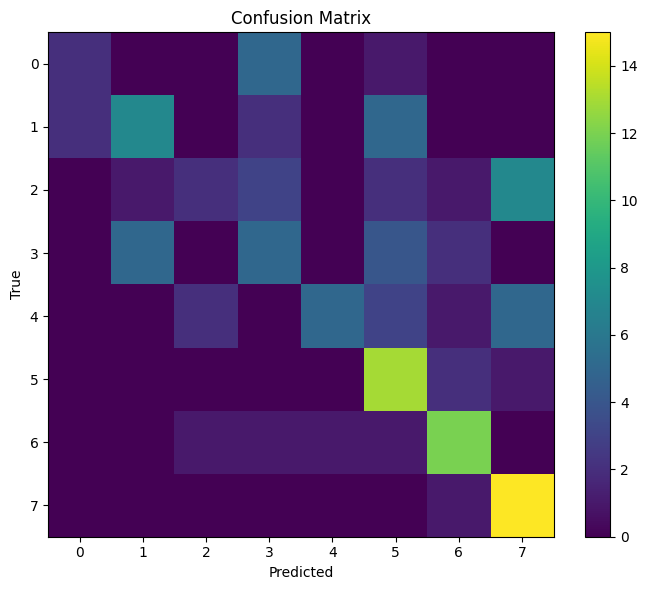

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.imshow(cm, aspect="auto", origin="upper")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


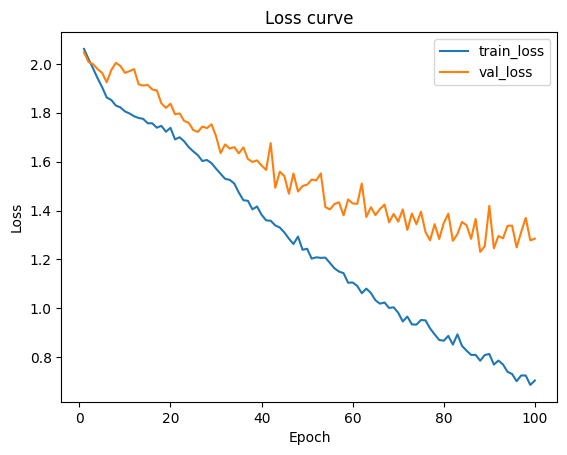

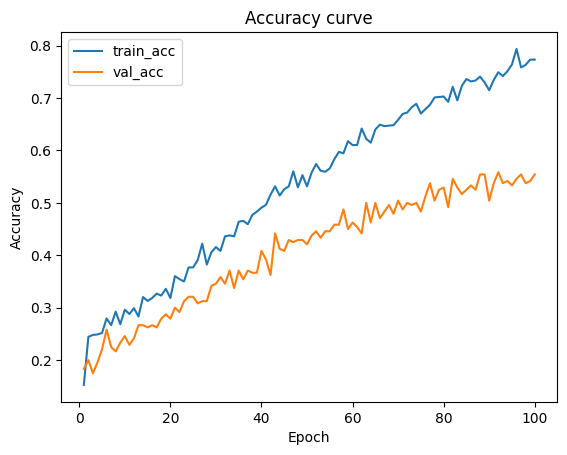

In [10]:
# PLOT DELLE CURVE DI ACCURACY E LOSS

import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss curve")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy curve")
    plt.legend()
    plt.show()

plot_history(history)


In [11]:
# PARAMETRI USATI
def print_training_summary(model, optimizer, train_loader, history):
    # Batch size
    batch_size = train_loader.batch_size

    # Numero epoche effettive (da history)
    epochs_done = len(history["train_loss"])

    # Optimizer name + LR
    optim_name = optimizer.__class__.__name__
    lr = optimizer.param_groups[0]["lr"]

    # Parametri modello (quanti pesi)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\n================ TRAINING SUMMARY ================")
    print(f"Batch size:        {batch_size}")
    print(f"Epochs:            {epochs_done}")
    print(f"Optimizer:         {optim_name}")
    print(f"Learning rate:     {lr}")
    print(f"Total params:      {total_params}")
    print(f"Trainable params:  {trainable_params}")
    print("==================================================\n")


import torch.nn as nn
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print_training_summary(model, optimizer, train_loader, history)



================ TRAINING SUMMARY ================
Batch size:        64
Epochs:            100
Optimizer:         Adam
Learning rate:     0.001
Total params:      657096
Trainable params:  657096

